# Binary Classification of meals with MobileNet V2


This task is an ANN pipeline that provides accurate binary classifications of unseen input images that contain either chips or rice. The datset used for experimentation in this notebook has been retrieved from the mlend python library that was curated by students and associated faculty of the QMUL EECS Introduction to Machine Learning class of late 2023.<br>

## Introduction

This is a transfer learning approach to leverage the architecture of a popular and efficient existing CNN, MobileNetV2, but made various tweaks so it could learn from our data and be used for binary classification. Our choice of an ANN was one that we approached with deliberation and caution, but felt it to be a good choice given the drop in the cost of compute for such models and their demonstrably high performance in image classification and computer vision more broadly. We did experiment with another architecture called EfficientNet, but it was promptly discarded due to its long training time and surprisingly poor accuracy compared to MobileNetV2, which is much faster due to its design for constrained resources (mobile devices, perhaps unsurprisingly). This was a few simple switches in the code so we did not preserve this for model selection.

MobileNetV2 has some interesting properties that allows it to deal effectively with complex detail in the images without being compromised by its compact size. One of the initial blocks in the architecture (Inverted Residual with Linear Bottleneck) permits the use of nonlinear activation functions such as ReLU to effectively capture complex patterns on the data manifold, the high-dimensional space where key features of the data exist. This is important, as nonlinear functions are more efficient in high-dimensional manifolds. This expansion is crucial for preserving information without compromising its efficiency in learning the essential features of the input data. This can be thought of as extracting features from the original (encoded) RGB 3-layer image.

the above is followed by a more conventional convolutional layer to deal with equivariance and compression, and batch normalisation layers, until it is then expanded once again with a depthwise seperable convolution, which is a simple convolutional layer with 3x3 kernels, followed by batch normalisation and a constrained ReLu.

Deeper architectures like mobilenetV2 work as a feature extractor in some respect so we go without an additional feature selection or extraction step in our pipeline. This is a strategic approach and we did consider an ensamble approach but addressing the weights of each model was a form of subjectivity and complexity we chose to avoid. The tweaks we make to the model are primarily the addition of a dense layer, and fine-tuning of the model by 'unfreezing' some of the existing layers so it could fit to our dataset. This fine-tuning process can be denoted as an optimization problem:

$$ \min_{W} \mathcal{L}(Y, f(X; W)) $$

Where $\mathcal{L}$ is the loss function, $Y$ are the true labels, $X$ is the input data, $W$ represents the weights of all trainable layers, and $f$ represents the model. Our (very manual) objective is to minimize the loss over all the trainable weights of the model.

We also change the output layer to a single neuron which will output a value $\sigma(x) \in (0, 1)$, the threshold of which for classification is determined by the ROC Curve.





In [ ]:
!pip install mlend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00


In [ ]:
import skimage as ski
import mlend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp
import os, sys, re, pickle, glob
import urllib.request
import zipfile
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from skimage import exposure
from mlend import download_yummy, yummy_load
from tqdm import tqdm
from google.colab import drive
from skimage import transform, io
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# download dataset and load
subset = {}
baseDir = download_yummy(save_to='/content/drive/MyDrive/Data/MLEnd', subset = subset,verbose=1)
print("Contents of baseDir:", os.listdir(baseDir))

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!
Contents of baseDir: ['MLEndYD_images', 'MLEndYD_image_attributes_benchmark.csv']


In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
raw_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test


In [ ]:
# convert the ingredients column to lowercase for matching
raw_df['Ingredients'] = raw_df['Ingredients'].str.lower()

# defininmg function to categorise ingredients
def categorize_ingredient(ingredient):
    if 'rice' in ingredient:
        return 'rice'
    elif 'chips' in ingredient or 'fries' in ingredient:
        return 'chips'
    else:
        return None

# apply function to create new column
raw_df['Rice_Chips'] = raw_df['Ingredients'].apply(categorize_ingredient)

MLENDYD_df = raw_df[raw_df['Rice_Chips'].notna()]

MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips
filename,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,rice
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,rice
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,rice
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,rice
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,rice
...,...,...,...,...,...,...,...,...,...,...,...,...
003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,rice
003236.jpg,non_vegetarian,german/turkish,german_turkish,german_doner_kebab,gdk,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",unhealthy,2.0,strongly_like,5.0,Train,chips
003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,rice


In [ ]:
# extract and encode labels for the entire DataFrame
labels = MLENDYD_df['Rice_Chips']
label_encoder = LabelEncoder()
Y_encoded_full = label_encoder.fit_transform(labels)

In [ ]:
def preprocess_image(file_path):
    I = io.imread(file_path)

    # confirming the data type is uint8 for correct scaling
    if I.dtype == np.uint8:
        I = I.astype(np.float32) / 255.0
    elif I.dtype == np.float32 or I.dtype == np.float64:
        pass
    else:
        raise ValueError(f"Unexpected data type: {I.dtype}")

    # make the image square and resize
    I = make_it_square(I, pad_color=0)
    I = resize_img(I, size=(224, 224))

    return I

In [ ]:
all_image_paths = MLENDYD_df.index.tolist()
all_image_paths = [os.path.join('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images', filename) for filename in all_image_paths]

# process all images with normalisation
X_all = []
# initialise list to keep track images
successful_indices = []
missing_files = 0

for k, file in tqdm(enumerate(all_image_paths), total=len(all_image_paths)):
    if not os.path.exists(file):
        missing_files += 1
        continue
    try:
        I = preprocess_image(file)
        X_all.append(I)
        successful_indices.append(k)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        missing_files += 1
        continue

X_all = np.array(X_all)
print(f"Processed images shape: {X_all.shape}")
print(f"Missing files: {missing_files}")

# align Y_encoded with the successfully processed images
Y_encoded = Y_encoded_full[successful_indices]

np.save('/content/drive/MyDrive/Data/MLEnd/X_array.npy', X_all)
np.save('/content/drive/MyDrive/Data/MLEnd/Y_array.npy', Y_encoded)

100%|██████████| 852/852 [46:35<00:00,  3.28s/it]


Processed images shape: (832, 224, 224, 3)
Missing files: 20


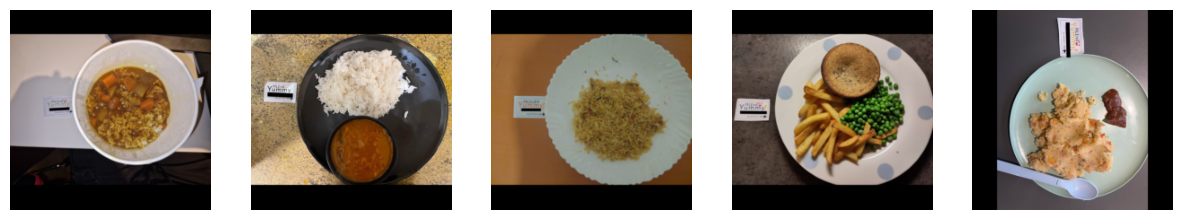

In [ ]:
X_all = np.load('/content/drive/MyDrive/Data/MLEnd/X_array.npy')

# display the first few images from array
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_all[i])
    plt.axis('off')

plt.show()

In [ ]:
X_array = np.load('/content/drive/MyDrive/Data/MLEnd/X_array.npy')
Y_array = np.load('/content/drive/MyDrive/Data/MLEnd/Y_array.npy')

In [ ]:
# split the dataset into training, validation, and test sets
X_fit, X_test, Y_fit, Y_test = train_test_split(X_array, Y_array, test_size=0.2, stratify=Y_array, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_fit, Y_fit, test_size=0.2, stratify=Y_fit, random_state=42)

In [ ]:
# load mobilenetv2 model, pre-trained on imagenet data
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze all layers of the base model initially
base_model.trainable = False

# layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # smaller dense layer with L2 regularization
x = Dropout(0.5)(x)  # add dropout
predictions = Dense(1, activation='sigmoid')(x)

# compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=2e-3), loss='binary_crossentropy', metrics=['accuracy'])

# class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(enumerate(class_weights))

# train the model with all layers frozen
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val, Y_val), class_weight=class_weights_dict)

# unfreeze the last n layers of the base model for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# recompile and continue training the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_data=(X_val, Y_val), class_weight=class_weights_dict)


yvp_prob = model.predict(X_val)

threshold = 0.90  # can adjust this based on my roc curve
yvp = (yvp_prob > threshold).astype(int)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
17/17 [==============================] - 29s 1s/step - loss: 6.2186 - accuracy: 0.7274 - val_loss: 4.1556 - val_accuracy: 0.9173
Epoch 2/10
17/17 [==============================] - 25s 1s/step - loss: 4.1511 - accuracy: 0.7425 - val_loss: 2.8791 - val_accuracy: 0.8872
Epoch 3/10
17/17 [==============================] - 24s 1s/step - loss: 2.6845 - accuracy: 0.8966 - val_loss: 2.1915 - val_accuracy: 0.8947
Epoch 4/10
17/17 [==============================] - 26s 2s/step - loss: 2.0628 - accuracy: 0.8590 - val_loss: 2.0189 - val_accuracy: 0.8346
Epoch 5/10
17/17 [==============================] - 23s 1s/step - loss: 1.6437 - accuracy: 0.8835 - val_loss: 1.6672 - val_accuracy: 0.8421
Epoch 6/10
17/17 [==============================] - 40s 2s/step - loss: 1.3526 - accuracy: 0.9342 - val_loss: 1.2198 - val_accuracy: 0.9398
Epoch 7/10
17/17 [==============================] - 34s 2s/step - loss: 1.1290 - accuracy: 0.9586

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Threshold:', optimal_threshold)

Optimal Threshold: 0.9395289


Validation Set Performance
Confusion Matrix:
 [[  9   3]
 [  9 112]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.75      0.60        12
           1       0.97      0.93      0.95       121

    accuracy                           0.91       133
   macro avg       0.74      0.84      0.77       133
weighted avg       0.93      0.91      0.92       133

5/5 [==============================] - 5s 876ms/step


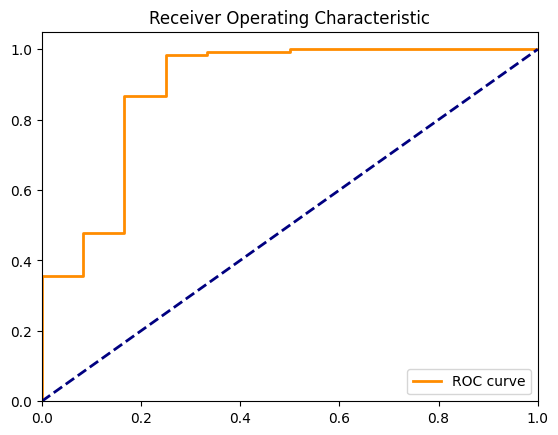

In [ ]:
# model 3
print("Validation Set Performance")
cm = confusion_matrix(Y_val, yvp)
print("Confusion Matrix:\n", cm)
report = classification_report(Y_val, yvp)
print("Classification Report:\n", report)
yvp_prob = model.predict(X_val)

# calculate roc curve and auc
fpr, tpr, thresholds = roc_curve(Y_val, yvp_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test Set Performance
6/6 [==============================] - 5s 798ms/step
Confusion Matrix:
 [[ 13   2]
 [ 12 140]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.87      0.65        15
           1       0.99      0.92      0.95       152

    accuracy                           0.92       167
   macro avg       0.75      0.89      0.80       167
weighted avg       0.94      0.92      0.93       167



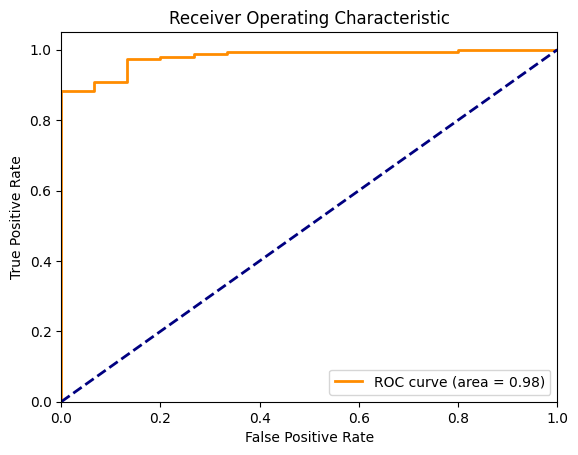

In [ ]:
# model 3 TEST SET

print("Test Set Performance")

# predictions for test data and threshold adjustment
y_test_prob = model.predict(X_test)
y_test_pred = (y_test_prob > threshold).astype(int)

cm = confusion_matrix(Y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

report = classification_report(Y_test, y_test_pred)
print("Classification Report:\n", report)

# calculate roc curve and auc
fpr, tpr, thresholds = roc_curve(Y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
